In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import seaborn as sns

In [19]:
class PCAAnalysis:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path

    def load_images(self):
        """Load and preprocess images."""
        self.image_data = []
        for file_name in sorted(os.listdir(self.dataset_path)):
            if file_name.endswith('.png'):  # Process only PNG files
                img = Image.open(os.path.join(self.dataset_path, file_name))
                img = img.resize((64, 64), Image.BILINEAR)  # Resize to 64x64
                img_array = np.array(img, dtype=np.float32)
                self.image_data.append(img_array)
        
        self.image_data = np.array(self.image_data)
        self.image_data_flattened = self.image_data.reshape(len(self.image_data), -1, 3)
        print(f"Loaded images: {len(self.image_data)}")
    
    def split_rgb_channels(self):
        """Split RGB channels into separate data structures."""
        print("Splitting RGB channels...")
        self.red_channel = self.image_data_flattened[:, :, 0]
        self.green_channel = self.image_data_flattened[:, :, 1]
        self.blue_channel = self.image_data_flattened[:, :, 2]
        print("RGB split complete.")

    def compute_pca(self, data):
        """Perform PCA and return sorted eigenvalues and eigenvectors."""
        mean = np.mean(data, axis=0)
        centered_data = data - mean
        covariance_matrix = np.cov(centered_data, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        sorted_indices = np.argsort(eigenvalues)[::-1]
        return eigenvalues[sorted_indices], eigenvectors[:, sorted_indices], mean

    def calculate_pve(self, eigenvalues):
        """Calculate PVE and cumulative PVE."""
        total_variance = np.sum(eigenvalues)
        pve = eigenvalues / total_variance
        cumulative_pve = np.cumsum(pve)
        return pve, cumulative_pve

    def display_pca_results(self, eigenvalues, pve, cumulative_pve, color_name):
        """Display the top 10 eigenvalues and PVE results for a color channel."""
        table_data = {
            "PC Number": np.arange(1, 12),
            "Eigenvalue": np.round(eigenvalues[:11], 2),
            "PVE": np.round(pve[:11], 3),
            "Cumulative PVE": np.round(cumulative_pve[:11], 3),
        }
        table_df = pd.DataFrame(table_data)
        print(f"\n{color_name} Values (X_{color_name[0]}):\n")
        print(table_df)
        print(f"Total PVE of top 10 principal components for {color_name}: {np.sum(pve[:10]):.3f}")
        print(
            f"Total PVE of top 11 principal components for {color_name}: {cumulative_pve[10]:.3f}\n"
        )

    def visualize_top_principal_components(self):
        """Visualize the top 10 principal components for RGB channels."""
        print("Visualizing top 10 principal components for each channel...")
        reshaped_red = self.red_eigenvectors[:, :10].T.reshape(10, 64, 64)
        reshaped_green = self.green_eigenvectors[:, :10].T.reshape(10, 64, 64)
        reshaped_blue = self.blue_eigenvectors[:, :10].T.reshape(10, 64, 64)

        normalized_R = np.array([self.normalize(pc) for pc in reshaped_red])
        normalized_G = np.array([self.normalize(pc) for pc in reshaped_green])
        normalized_B = np.array([self.normalize(pc) for pc in reshaped_blue])

        rgb_images = np.stack((normalized_R, normalized_G, normalized_B), axis=-1)  # Shape: (10, 64, 64, 3)

        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        for i, ax in enumerate(axes.flat):
            ax.imshow(rgb_images[i])
            ax.set_title(f"PC {i + 1}")
            ax.axis("off")
        plt.tight_layout()
        plt.show()

    def normalize(self, matrix):
        """Normalize a matrix for visualization."""
        min_val = np.min(matrix)
        max_val = np.max(matrix)
        return (matrix - min_val) / (max_val - min_val)

    def reconstruct_image(self, channel_data, eigenvalues, eigenvectors, mean, k):
        """Reconstruct the image using the top k principal components."""
        top_k_vectors = eigenvectors[:, :k]
        projection = np.dot(channel_data - mean, top_k_vectors)
        reconstruction = np.dot(projection, top_k_vectors.T) + mean
        return reconstruction

    def visualize_reconstruction(self, k_values):
        """Visualize reconstructed images."""
        for k in k_values:
            red_reconstructed = self.reconstruct_image(
                self.red_channel[0], self.red_eigenvalues, self.red_eigenvectors, self.red_mean, k
            ).reshape(64, 64)
            green_reconstructed = self.reconstruct_image(
                self.green_channel[0], self.green_eigenvalues, self.green_eigenvectors, self.green_mean, k
            ).reshape(64, 64)
            blue_reconstructed = self.reconstruct_image(
                self.blue_channel[0], self.blue_eigenvalues, self.blue_eigenvectors, self.blue_mean, k
            ).reshape(64, 64)

            reconstructed_image = np.stack([red_reconstructed, green_reconstructed, blue_reconstructed], axis=-1)

            plt.imshow(reconstructed_image / 255)
            plt.title(f"Reconstruction with {k} components")
            plt.axis("off")
            plt.show()

    def run(self):
        """Run the PCA analysis and visualize results."""
        self.load_images()
        self.split_rgb_channels()

        # Perform PCA for the Red channel
        print("Performing PCA on Red Channel...")
        self.red_eigenvalues, self.red_eigenvectors, self.red_mean = self.compute_pca(self.red_channel)
        red_pve, red_cumulative_pve = self.calculate_pve(self.red_eigenvalues)
        self.display_pca_results(self.red_eigenvalues, red_pve, red_cumulative_pve, "Red")

        # Perform PCA for the Green channel
        print("Performing PCA on Green Channel...")
        self.green_eigenvalues, self.green_eigenvectors, self.green_mean = self.compute_pca(self.green_channel)
        green_pve, green_cumulative_pve = self.calculate_pve(self.green_eigenvalues)
        self.display_pca_results(self.green_eigenvalues, green_pve, green_cumulative_pve, "Green")

        # Perform PCA for the Blue channel
        print("Performing PCA on Blue Channel...")
        self.blue_eigenvalues, self.blue_eigenvectors, self.blue_mean = self.compute_pca(self.blue_channel)
        blue_pve, blue_cumulative_pve = self.calculate_pve(self.blue_eigenvalues)
        self.display_pca_results(self.blue_eigenvalues, blue_pve, blue_cumulative_pve, "Blue")

        # Visualize top 10 principal components
        self.visualize_top_principal_components()

        # Reconstruction and visualization
        k_values = [1, 50, 250, 500, 1000, 4096]
        self.visualize_reconstruction(k_values)



Loaded images: 10000
Splitting RGB channels...
RGB split complete.
Performing PCA on Red Channel...

Red Values (X_R):

    PC Number  Eigenvalue    PVE  Cumulative PVE
0           1  4600717.59  0.289           0.289
1           2  1490755.88  0.094           0.383
2           3  1079651.58  0.068           0.451
3           4   931817.15  0.059           0.510
4           5   861886.54  0.054           0.564
5           6   697277.54  0.044           0.608
6           7   459258.50  0.029           0.636
7           8   325894.55  0.020           0.657
8           9   267429.29  0.017           0.674
9          10   259337.43  0.016           0.690
10         11   198816.80  0.013           0.703
Total PVE of top 10 principal components for Red: 0.690
Total PVE of top 11 principal components for Red: 0.703

Performing PCA on Green Channel...

Green Values (X_G):

    PC Number  Eigenvalue    PVE  Cumulative PVE
0           1  4621729.32  0.320           0.320
1           2  1234628.4

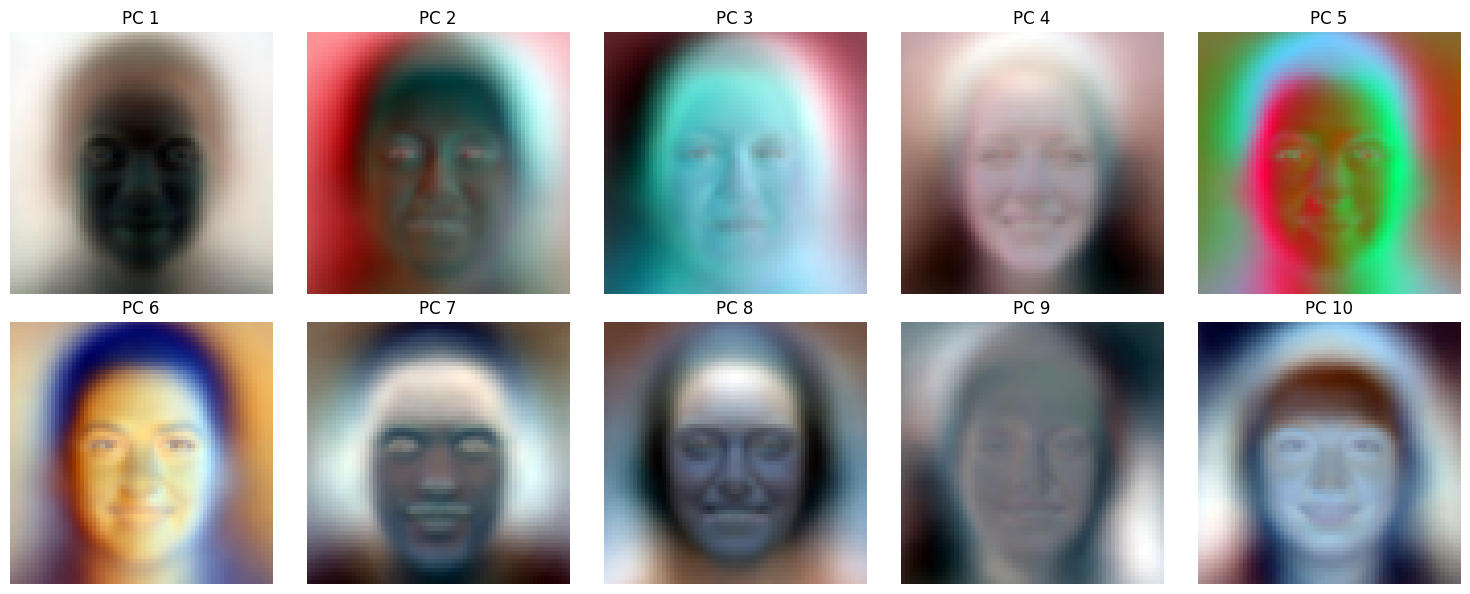

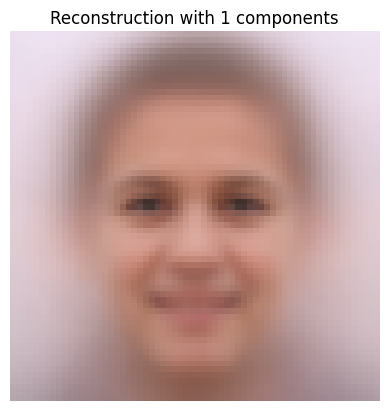

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.01829436596591639..1.1940787223376472].


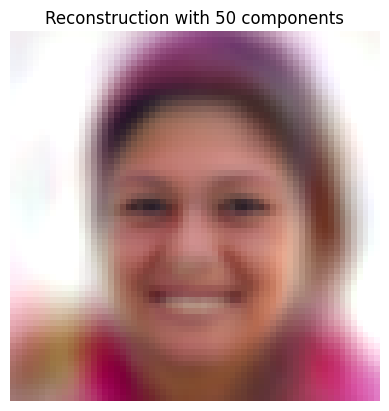

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.010033838324490401..1.1329864082958194].


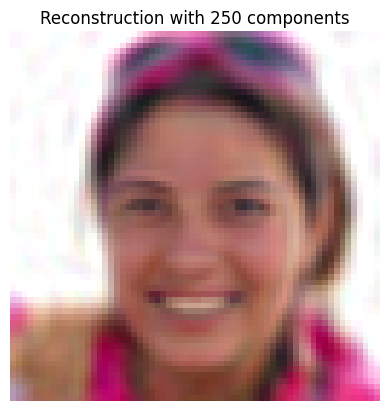

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.027238822842098404..1.1089622742154834].


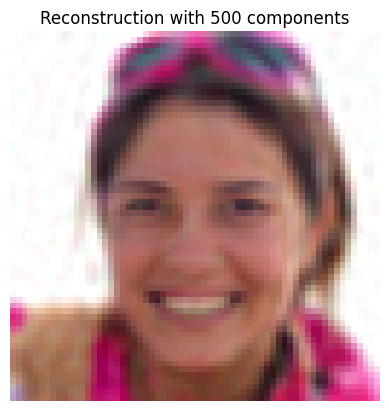

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.007224363401388923..1.0557162955925012].


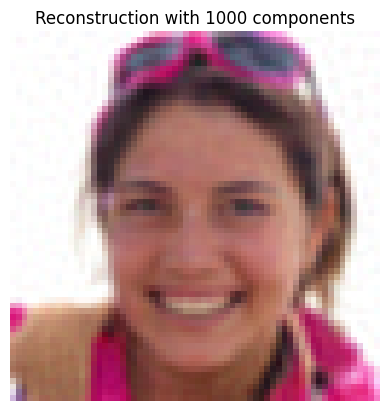

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.027450980392156585..1.000000029919199].


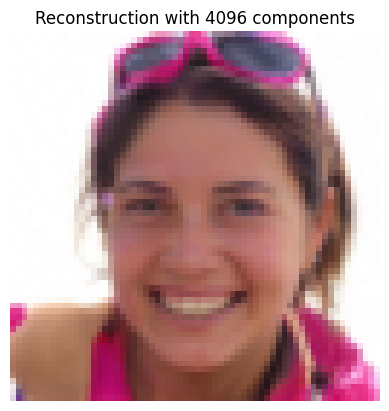

In [20]:
dataset_path = "/Users/elifsorguc/Desktop/Bilkent/ML/MachineLearning-PCA-LogReg/data/fake"

# Perform PCA Analysis
pca = PCAAnalysis(dataset_path)
pca.run()

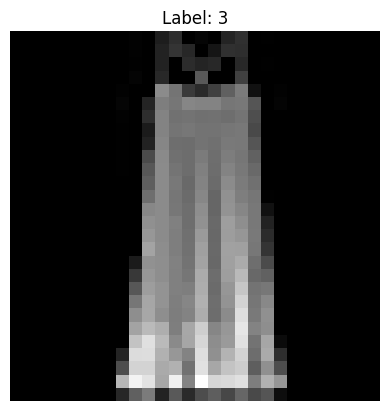

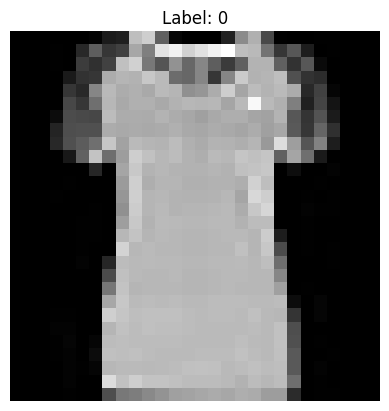

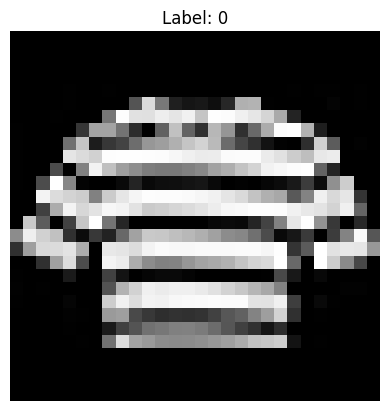

Epoch 1/50, Validation Accuracy: 0.1429
Epoch 2/50, Validation Accuracy: 0.1452
Epoch 3/50, Validation Accuracy: 0.1576
Epoch 4/50, Validation Accuracy: 0.1736
Epoch 5/50, Validation Accuracy: 0.1878
Epoch 6/50, Validation Accuracy: 0.2064
Epoch 7/50, Validation Accuracy: 0.2264
Epoch 8/50, Validation Accuracy: 0.2487
Epoch 9/50, Validation Accuracy: 0.2690
Epoch 10/50, Validation Accuracy: 0.2880
Epoch 11/50, Validation Accuracy: 0.3057
Epoch 12/50, Validation Accuracy: 0.3205
Epoch 13/50, Validation Accuracy: 0.3330
Epoch 14/50, Validation Accuracy: 0.3450
Epoch 15/50, Validation Accuracy: 0.3568
Epoch 16/50, Validation Accuracy: 0.3672
Epoch 17/50, Validation Accuracy: 0.3762
Epoch 18/50, Validation Accuracy: 0.3848
Epoch 19/50, Validation Accuracy: 0.3930
Epoch 20/50, Validation Accuracy: 0.4017
Epoch 21/50, Validation Accuracy: 0.4083
Epoch 22/50, Validation Accuracy: 0.4149
Epoch 23/50, Validation Accuracy: 0.4218
Epoch 24/50, Validation Accuracy: 0.4270
Epoch 25/50, Validation A

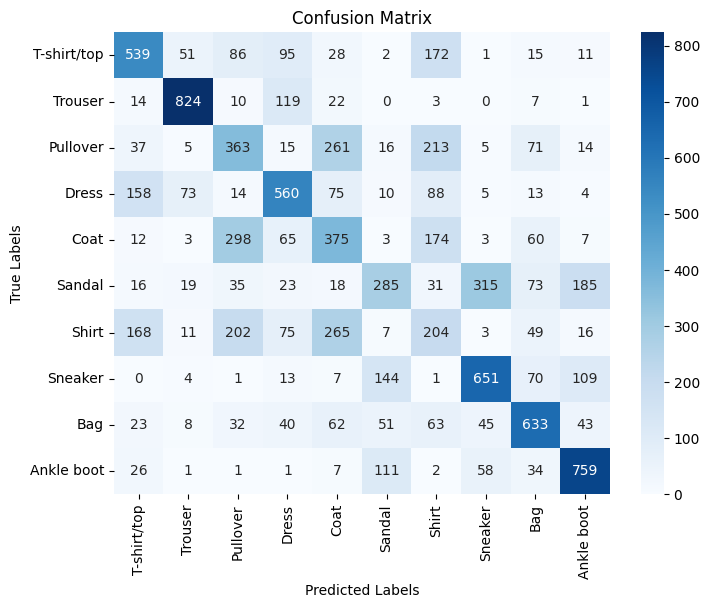

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function for one-hot encoding
def one_hot_encoding(label_data):
    num_samples = label_data.shape[0]
    num_classes = 10  # Assuming 10 classes (0-9)
    encoded_labels = np.zeros((num_samples, num_classes), dtype='int')
    encoded_labels[np.arange(num_samples), label_data] = 1
    return encoded_labels


# Function to read pixel data
def read_pixels(data_path):
    with open(data_path, 'rb') as f:
        raw_data = np.frombuffer(f.read(), dtype=np.uint8, offset=16)
    flattened_pixels = raw_data.reshape(-1, 784).astype('float32')
    return flattened_pixels / 255.0


# Function to read label data
def read_labels(data_path):
    with open(data_path, 'rb') as f:
        raw_labels = np.frombuffer(f.read(), dtype=np.uint8, offset=8)
    return one_hot_encoding(raw_labels)


# Function to load the MNIST dataset
def load_mnist_data(path):
    X_train = read_pixels(os.path.join(path, "train-images-idx3-ubyte"))
    y_train = read_labels(os.path.join(path, "train-labels-idx1-ubyte"))
    X_test = read_pixels(os.path.join(path, "t10k-images-idx3-ubyte"))
    y_test = read_labels(os.path.join(path, "t10k-labels-idx1-ubyte"))
    return X_train, y_train, X_test, y_test


# Logistic Regression Model
class LogisticRegression:
    def __init__(self, learning_rate=1e-3, reg_lambda=1e-4, epochs=50, batch_size=200, input_dim=784, output_dim=10):
        self.learning_rate = learning_rate
        self.reg_lambda = reg_lambda
        self.epochs = epochs
        self.batch_size = batch_size
        self.weights = np.random.normal(0, 1, (input_dim, output_dim))
        self.biases = np.zeros((1, output_dim))

    def softmax(self, logits):
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))  # Numerical stability
        return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_true, y_pred):
        return -np.mean(np.sum(y_true * np.log(y_pred + 1e-9), axis=1))  # Avoid log(0)

    def train(self, X_train, y_train, X_val, y_val):
        num_samples = X_train.shape[0]
        for epoch in range(self.epochs):
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            X_train, y_train = X_train[indices], y_train[indices]

            for start in range(0, num_samples, self.batch_size):
                X_batch = X_train[start:start + self.batch_size]
                y_batch = y_train[start:start + self.batch_size]

                # Forward pass
                logits = np.dot(X_batch, self.weights) + self.biases
                predictions = self.softmax(logits)

                # Compute gradients
                error = predictions - y_batch
                grad_weights = np.dot(X_batch.T, error) / self.batch_size + self.reg_lambda * self.weights
                grad_biases = np.sum(error, axis=0, keepdims=True) / self.batch_size

                # Update weights and biases
                self.weights -= self.learning_rate * grad_weights
                self.biases -= self.learning_rate * grad_biases

            # Print validation accuracy for each epoch
            val_accuracy = self.evaluate(X_val, y_val)
            print(f"Epoch {epoch + 1}/{self.epochs}, Validation Accuracy: {val_accuracy:.4f}")

    def predict(self, X):
        logits = np.dot(X, self.weights) + self.biases
        return np.argmax(self.softmax(logits), axis=1)

    def evaluate(self, X, y_true):
        y_pred = self.predict(X)
        y_true_labels = np.argmax(y_true, axis=1)
        return np.mean(y_true_labels == y_pred)


# Display sample images
def display_sample_images(X_test, y_test, num_samples=3):
    indices = np.random.choice(len(X_test), num_samples, replace=False)
    for i, idx in enumerate(indices):
        image = X_test[idx].reshape(28, 28)
        label = np.argmax(y_test[idx])
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
        plt.show()


# Plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()


# Main Execution
if __name__ == "__main__":
    dataset_path = "/Users/elifsorguc/Desktop/Bilkent/ML/MachineLearning-PCA-LogReg/data/mnist"

    # Load dataset
    X_train, y_train, X_test, y_test = load_mnist_data(dataset_path)

    # Display sample images
    display_sample_images(X_test, y_test, num_samples=3)

    # Split validation set from training data
    X_val, y_val = X_train[:10000], y_train[:10000]
    X_train, y_train = X_train[10000:], y_train[10000:]

    # Train model
    model = LogisticRegression()
    model.train(X_train, y_train, X_val, y_val)

    # Generate confusion matrix
    y_test_pred = model.predict(X_test)
    y_test_true = np.argmax(y_test, axis=1)
    cm = np.zeros((10, 10), dtype=int)
    for true, pred in zip(y_test_true, y_test_pred):
        cm[true, pred] += 1

    # Plot confusion matrix
    class_names = [
        "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
        "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
    ]
    plot_confusion_matrix(cm, class_names)


Epoch 1/100, Loss: 14.9680, Validation Accuracy: 0.0633
Epoch 2/100, Loss: 13.1934, Validation Accuracy: 0.0658
Epoch 3/100, Loss: 11.4470, Validation Accuracy: 0.0727
Epoch 4/100, Loss: 11.5788, Validation Accuracy: 0.0838
Epoch 5/100, Loss: 10.6542, Validation Accuracy: 0.0932
Epoch 6/100, Loss: 9.6055, Validation Accuracy: 0.1064
Epoch 7/100, Loss: 9.7713, Validation Accuracy: 0.1168
Epoch 8/100, Loss: 8.7182, Validation Accuracy: 0.1291
Epoch 9/100, Loss: 8.4633, Validation Accuracy: 0.1391
Epoch 10/100, Loss: 7.6597, Validation Accuracy: 0.1514
Epoch 11/100, Loss: 8.3464, Validation Accuracy: 0.1629
Epoch 12/100, Loss: 7.5670, Validation Accuracy: 0.1750
Epoch 13/100, Loss: 8.3883, Validation Accuracy: 0.1862
Epoch 14/100, Loss: 7.1532, Validation Accuracy: 0.1970
Epoch 15/100, Loss: 7.0218, Validation Accuracy: 0.2092
Epoch 16/100, Loss: 7.4709, Validation Accuracy: 0.2202
Epoch 17/100, Loss: 7.1263, Validation Accuracy: 0.2319
Epoch 18/100, Loss: 6.1342, Validation Accuracy: 0.2

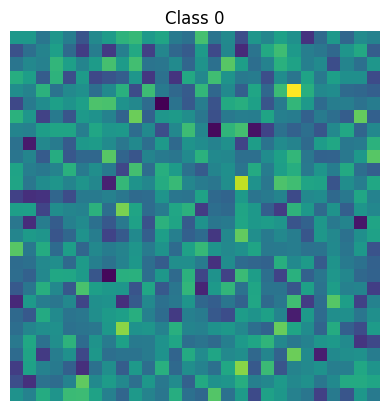

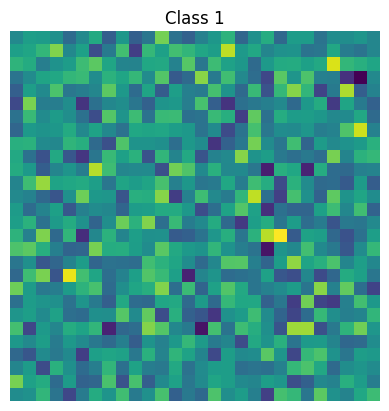

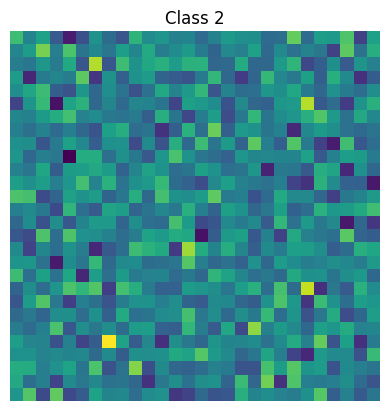

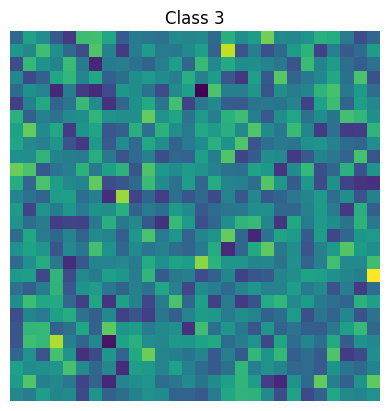

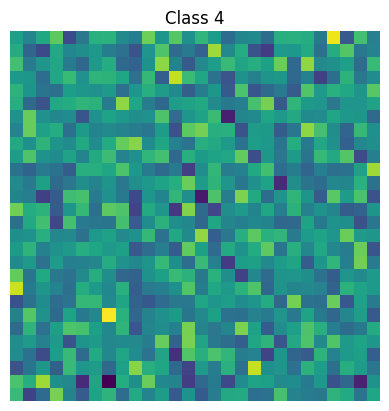

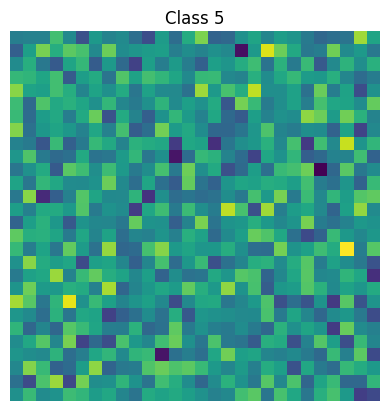

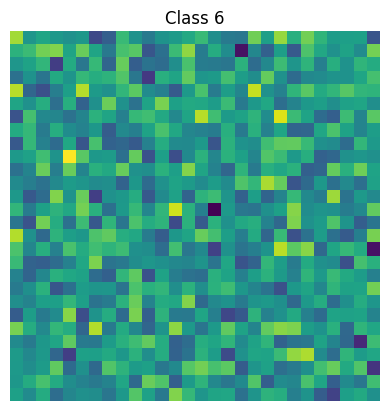

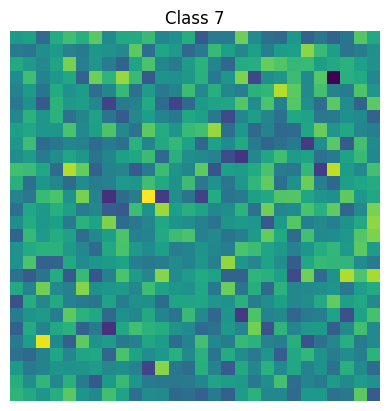

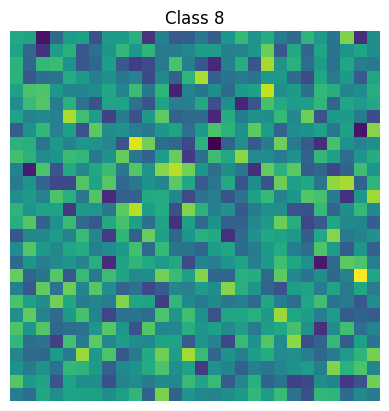

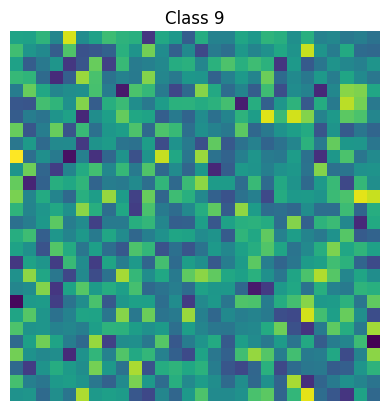

In [30]:

# Main script
dataset_path = "/Users/elifsorguc/Desktop/Bilkent/ML/MachineLearning-PCA-LogReg/data/mnist"
X_train, y_train, X_test, y_test = read_dataset(dataset_path)

# Split a validation set from the training data
split_idx = int(len(X_train) * 0.8)
X_val, y_val = X_train[split_idx:], y_train[split_idx:]
X_train, y_train = X_train[:split_idx], y_train[:split_idx]

# Default model training
model = LogisticRegression(input_size=784, num_classes=10)
history = model.train(X_train, y_train, X_val, y_val)

# Test performance
test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Weight Visualization
visualize_weights(model.weights)

Epoch 1/100, Loss: 77.9527
Epoch 2/100, Loss: 76.7534
Epoch 3/100, Loss: 75.6026
Epoch 4/100, Loss: 74.4955
Epoch 5/100, Loss: 73.4273
Epoch 6/100, Loss: 72.3966
Epoch 7/100, Loss: 71.4000
Epoch 8/100, Loss: 70.4405
Epoch 9/100, Loss: 69.5170
Epoch 10/100, Loss: 68.6239
Epoch 11/100, Loss: 67.7644
Epoch 12/100, Loss: 66.9365
Epoch 13/100, Loss: 66.1346
Epoch 14/100, Loss: 65.3576
Epoch 15/100, Loss: 64.6075
Epoch 16/100, Loss: 63.8878
Epoch 17/100, Loss: 63.2034
Epoch 18/100, Loss: 62.5583
Epoch 19/100, Loss: 61.9487
Epoch 20/100, Loss: 61.3656
Epoch 21/100, Loss: 60.8052
Epoch 22/100, Loss: 60.2665
Epoch 23/100, Loss: 59.7496
Epoch 24/100, Loss: 59.2548
Epoch 25/100, Loss: 58.7824
Epoch 26/100, Loss: 58.3323
Epoch 27/100, Loss: 57.9035
Epoch 28/100, Loss: 57.4958
Epoch 29/100, Loss: 57.1090
Epoch 30/100, Loss: 56.7402
Epoch 31/100, Loss: 56.3863
Epoch 32/100, Loss: 56.0465
Epoch 33/100, Loss: 55.7207
Epoch 34/100, Loss: 55.4090
Epoch 35/100, Loss: 55.1103
Epoch 36/100, Loss: 54.8232
E